# Q2

In [165]:
from scipy.integrate import solve_bvp
import numpy as np
import matplotlib.pyplot as plt
import math

### Boundary Value Problem

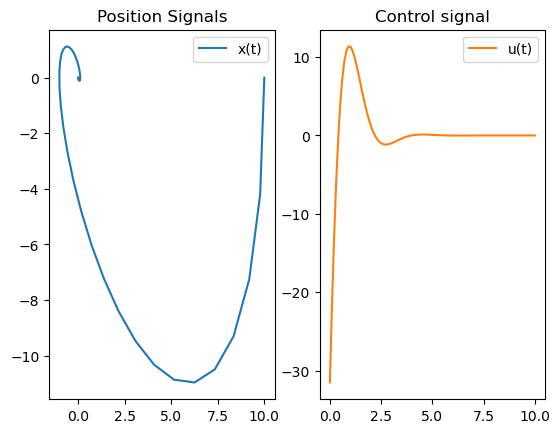

In [227]:
#Create our independent variable nodes. 
t = np.linspace(0,10,100)

#Create our matrices.
A = np.array([[0, 1],
            [-1.6, -0.4]])

B = np.array([[0], 
              [1]])

Q = np.array([[2, 0],
            [0, 0.01]])

R = np.array([0.1])

P1 = np.array([[1, 0],
            [0, 0.01]])

# The order that we implement this is crucial. In this case, 
# we will solve the xdot function first.

## Create our function

#Reshape because numpy reads the matrix as a (R,) instead of a (R,1) which throws an error.
#None created a Row vector when placed before, and a Column vector when placed after. Replaces the "lost" axis when slicing.
def bvp(x,y):
    return np.vstack((A[None,0] @ np.vstack([y[0],y[1]]) - ((B @ (1/R)).reshape(2,1) @ B.T)[None,0] @ np.vstack([y[2],y[3]]), ##x_dot1 
                      A[None,1] @ np.vstack([y[0],y[1]]) - ((B @ (1/R)).reshape(2,1) @ B.T)[None,1] @ np.vstack([y[2],y[3]]), ##x_dot2
                     -Q[None,0] @ np.vstack([y[0],y[1]]) - A.T[None,0] @ np.vstack([y[2],y[3]]),   ##p_dot1
                     -Q[None,1] @ np.vstack([y[0],y[1]]) - A.T[None,1] @ np.vstack([y[2],y[3]]),   ##p_dot2
                     ))

#Create our boundary conditions
def bc(ya, yb):
    return np.array([ya[0] - 10,
                     ya[1],
                     yb[2] - (P1.T[0] @ np.vstack([yb[0],yb[1]]))[0], #Indexing prevents any deprecation issues in NumPy
                     yb[3] - (P1.T[1] @ np.vstack([yb[0],yb[1]]))[0]
                    ])
#Create our guess 
y = np.zeros((4,t.size))

#Call our function
sol = solve_bvp(bvp, bc, t, y, verbose=0) #Change verbosity to have an idea of the kind of 

#Create our solution arrays
xsol = sol.y[(0,1),:]
psol = sol.y[(2,3),:] 
usol = -(1/R) @ B.T @ psol

#Plot the x and u control signals. 
fig, axs = plt.subplots(1,2)
axs[0].plot(xsol[0],xsol[1], label="x(t)")
# axs[0].plot(t,xsol[1], "tab:red", label="x2(t)")
axs[0].set_title("Position Signals")
axs[0].legend()

#Plotting the control signal 
axs[1].plot(t, usol, "tab:orange", label="u(t)")
axs[1].set_title("Control signal")
axs[1].legend()

### Directional Derivatives